# Navigation

Run this notebook end-to-end to complete Project 1 - Navigation of Udacity's Deep Reinforcement Learning Nanodegree program.

---

### 1. Setup the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


Import all python packages needed to execute the notebook.

In [2]:
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from unityagents import UnityEnvironment

The environment is already saved in the Workspace and can be accessed at the file path provided below.  However, if running this notebook locally, change `PATH_TO_ENV` to the appropriate file path.

In [3]:
PATH_TO_ENV = "/data/Banana_Linux_NoVis/Banana.x86_64"
env = UnityEnvironment(file_name=PATH_TO_ENV)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


**Aside**: Unity environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print(f"Number of agents: {len(env_info.agents)}")

# number of actions
ACTION_SIZE = brain.vector_action_space_size
print(f"Number of actions: {ACTION_SIZE}")

# examine the state space 
state = env_info.vector_observations[0]
print(f"States look like:\n{state}")
STATE_SIZE = len(state)
print(f"States have length: {STATE_SIZE}")

Number of agents: 1
Number of actions: 4
States look like:
[ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will see how to use the Python API to control the agent and receive feedback from the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

# run one episode
while True:
    action = np.random.randint(ACTION_SIZE)        # select a random action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print(f"Score: {score}")

Score: 0.0


### 4. Train the agent

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

- All of the source code (`Agent`, `Model`, and `ReplayBuffer`) are defined under `src/`. Feel free to inspect these files to see explicitly what each is contributing to the final result.

The algorithm we use is the **Deep Q Network**. More information about the different components is below:

* Model: The model is a fully-connected neural network. The input shape is the size of the state space (37), and the output shape is the size of the action space (4). The baseline implementation is a two layer network, where each of the hidden layers are sized with 64 neurons each. The network architecture (number of layers and/or size of layers) can be modified in `src/model.py`.

* Replay Buffer: The replay buffer is a first-in-first-out queue that stores experiences tuples consisting of `{state, action, reward, done, next state}`. When it comes time to train, we draw a uniform random sample from the replay buffer to better handle to correlation between consecutive states. A future modification to the implementation would be to use a prioritization factor, which would be used in sampling and weight experiences with higher rewards more and experiences with lower rewards less.

* Agent: The agent is consumes the model and the replay buffer to act and train within our environment. We use two Q networks to help prevent the tendency for Q values to inflate artificially and potentially learn locally optimal behaviors at the expense of globally optimal behaviors.

The DQN training algorithm is defined in the function below.

In [7]:
def dqn(agent,
        brain_name,
        n_episodes=2000,
        eps_start=1.0,
        eps_end=0.01,
        eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        agent (Agent): the agent to use for training
        brain_name (str): the brain name to use for the environment
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        
        while True:
            action = agent.act(state, eps)                 # select an action
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:
                break 
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        if np.mean(scores_window)>=13.0:
            print('\n\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            best_model = agent.qnetwork_local.state_dict(),
            break
    
    return scores, best_model

Import the agent and train via DQN.

In [8]:
from src.dqn_agent import Agent

agent = Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, seed=0)
scores, best_model = dqn(agent, brain_name)

Episode 100	Average Score: 1.15
Episode 200	Average Score: 4.48
Episode 300	Average Score: 6.94
Episode 400	Average Score: 9.54
Episode 500	Average Score: 12.80
Episode 528	Average Score: 13.03

Environment solved in 528 episodes!	Average Score: 13.03


### 5. Visualize results and save best model

Now that training is complete, we can visualize how training progressed over each episode and save the best version of the agent.

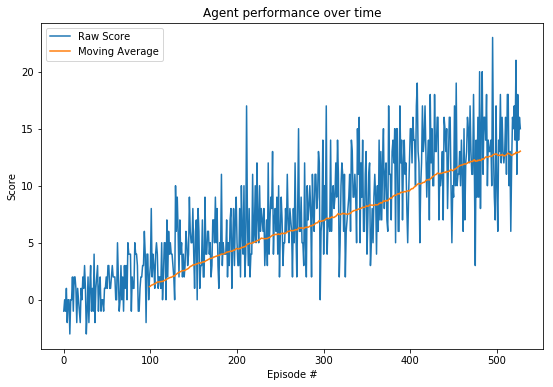

In [9]:
# plot the scores
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label="Raw Score")

# plot the moving average
scores_series = pd.Series(scores)
windows = scores_series.rolling(100)
ma = windows.mean().dropna()
x, y = ma.index, ma.values
plt.plot(x, y, label="Moving Average")

plt.xlabel("Episode #")
plt.ylabel("Score")
plt.title("Agent performance over time")
plt.legend()

fig.savefig("images/performance.png")

In [10]:
# save model
torch.save(best_model, "checkpoint.pth")

In [11]:
# close environment
env.close()

### 6. Potential improvements

The DQN implementation provided is fairly straightforward, and yet, solves the environment relatively quickly. Some things that are currently implemented include:

* Fully connected neural network representing the Q network
* Two Q networks, local and target
* Epsilon greedy action sampling
* Uniform random sampling of the replay buffer
* Fixed learning rate

Some additional ideas that could lead to better performance include or interesting insights

* Different model architectures (more/less layers, larger/smaller layer sizes)
* Dueling Q networks
* Prioritized sampling from the replay buffer
* Variable learning rates